This notebook will be aimed at exploring the distribution of fires/non-fires geographically. After building out some plotting functionality in another repository ([dsfuncs](https://github.com/sallamander/dsfuncs)), I'll be using it to plot fires. I'll start off by focusing on counties that have had a good number of fires in 2015, and look at the distribution of fires/non-fires in those counties in 2015 (and probably in a one month span). After that, I'll move to looking at the distribution of fires/non-fires in those same counties, but in earlier years. I'm aiming to explore the data to identify patterns that I might use in modeling, and specifically looking to see if: 

1. Fires clump together, as we might expect. Since the "detected fires" are just centroids detected at one point in the day, it seems reasonable to expect that multiple centroids that are truly fires would be detected close to each other in time and space. 
2. Fires are not present in the same locations from year to year. Forest-fires are often described as cyclical in nature, at least when we look at the same location across time. I'll be looking to try to confirm this (or support this) with this exploration here. 

The first thing I'll need to do is read in the data and figure out how to parse it to a given state and/or county. I'm going to intially focus on forest-fires in Washington, California, Colorado, Montana, and Texas. I think this will give me a reasonable mix of places that have enough potential fires to look at, while still being somewhat geographically diverse (unfortunately nothing in the east will really have enough). 

In [1]:
import pandas as pd
from dsfuncs.geo_plotting import StateMap
import matplotlib.pyplot as plt
%matplotlib inline

The first step will be to create functions to read in the data, and then only grab those rows of the data set that correspond to a given location (state & county) as well as a given month (or months). 

In [2]:
def read_df(year, modis=True): 
    """This function will read in a year of data, and add a month column. 
    
    Args: 
        year: str
        
    Return:
        Pandas DataFrame
    """
    if modis: 
        output_df = pd.read_csv('../../../data/csvs/detected_fires_MODIS_' + str(year) + '.csv', 
                                parse_dates=['date'], true_values=['t'], false_values=['f'])
    else: 
         output_df = pd.read_csv('../../../data/csvs/detected_fires_VIIRS_' + str(year) + '.csv', 
                                parse_dates=['date'], true_values=['t'], false_values=['f'])
    output_df['month'] = output_df.date.apply(lambda dt: dt.strftime('%B'))
    return output_df
    
def grab_by_location(df, state_names, county_names=None): 
    """Grab the data for a specified inputted state and county. 
    
    Args: 
        df: Pandas DataFrame
        state: set (or iterable of strings)
        county: set (or iterable of strings)
    
    Return: 
        Pandas DataFrame
    """
    if county_names: 
        output_df = df.query('state_name in @state_names and county_name in @county_names')
    else: 
        output_df = df.query('state_name in @state_names')
    return output_df

def grab_by_date(df, months): 
    """Grab the data for a set of specified months.
    
    Args: 
        df: Pandas DataFrame
        months: set (or iterable of strings)
    
    Return: 
        Pandas DataFrame
    """
    
    output_df = df.query("month in @months")
    return output_df

The next step is to just parse the data to get it into a format to plot. The format that the `CountyMap` class will expect the data to be in is an iterable of three items: 

1. Longitude of the point. 
2. Latitude of the point. 
3. Color to plot the point in. 

I'll create a function that will take in the previously parsed location/date DataFrame and get the data set up to be in that format. 

In [3]:
def format_df(df): 
    """Format the data to plot it on maps. 
    
    This function will grab the latitude and longitude 
    columns of the DataFrame, and return those, along 
    with a third column that will be newly generated. This 
    new column will hold what color we want to use to plot 
    the lat/long coordinate - I'll use red for fire and 
    green for non-fire. 
    
    Args: 
        df: Pandas DataFrame
    
    Return: 
        numpy.ndarray
    """
    
    keep_cols = ['long', 'lat', 'fire_bool']
    intermediate_df = df[keep_cols]
    output_df = parse_fire_bool(intermediate_df)
    output_array = output_df.values
    return output_array

def parse_fire_bool(df): 
    """Parse the fire boolean to a color for plotting. 
    
    Args: 
        df: Pandas DataFrame
        
    Return: 
        Pandas DataFrame
    """
    
    # Plot actual fires red and non-fires green. 
    output_df = df.drop('fire_bool', axis=1)
    output_df['plotting_mark'] = df['fire_bool'].apply(lambda f_bool: 'ro' if f_bool == True else 'go')
    return output_df

Now let's put all of this into a master function. 

In [4]:
def read_n_parse(year, state_names, county_names=None, months=None, plotting=False): 
    """Read and parse the data for plotting.
    
    Args: 
        year: str
        state_names: set (or other iterable) of state names
    Return: 
        Pandas DataFrame
    """
    fires_df = read_df(year)
    if state_names: 
        fires_df = grab_by_location(fires_df, state_names, county_names)
    
    if months: 
        fires_df = grab_by_date(fires_df, months)
    
    if plotting: 
        fires_df = format_df(fires_df)
    return fires_df

def plot_states(year, state_names, months=None, plotting=True): 
    """Plot a state map and the given fires data points for that state. 
    
    Args: 
        year: str
        state_names: set (or other iterable) of state names
    """
    ax = plt.subplot(1, 2, 1)
    state_map = StateMap('data/state_shapefiles_2014/cb_2014_us_state_500k2.shp', 
                        state_names, ax=ax)
    fires_data = read_n_parse(year, state_names, months=months, plotting=plotting)
    fires_data_trues = fires_data[fires_data[:,2] == 'ro']
    fires_data_falses = fires_data[fires_data[:,2] == 'go']
    print fires_data_trues.shape, fires_data_falses.shape
    state_map.plot_points(fires_data_trues)
    ax = plt.subplot(1, 2, 2)
    state_map = StateMap('data/state_shapefiles_2014/cb_2014_us_state_500k2.shp', 
                        state_names, ax=ax)
    state_map.plot_points(fires_data_falses)
    plt.show()

In [5]:
years = ['2012', '2013', '2014', '2015']
months = ['January', 'February', 'March', 'April', 'June', 'July', 'August', 'September', 'October', 
         'November', 'December']

Year: 2012, Month: January
(0, 3) (126, 3)


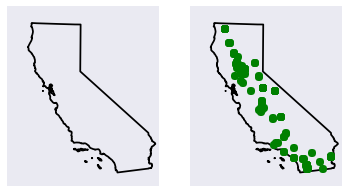

Year: 2013, Month: January
(0, 3) (131, 3)


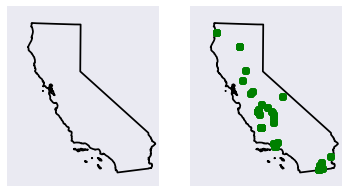

Year: 2014, Month: January
(35, 3) (696, 3)


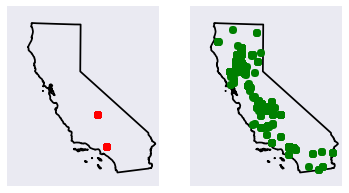

Year: 2015, Month: January
(0, 3) (139, 3)


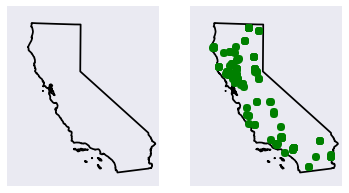

Year: 2012, Month: February
(1, 3) (115, 3)


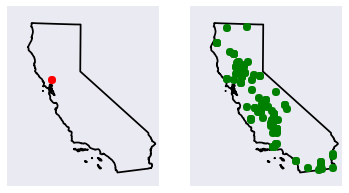

Year: 2013, Month: February
(3, 3) (538, 3)


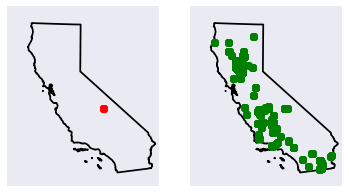

Year: 2014, Month: February
(0, 3) (744, 3)


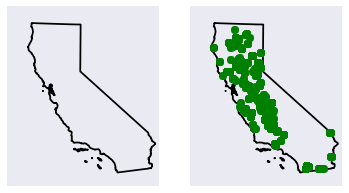

Year: 2015, Month: February
(0, 3) (297, 3)


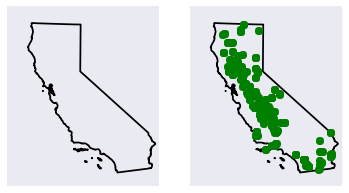

Year: 2012, Month: March
(0, 3) (130, 3)


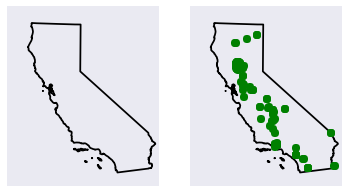

Year: 2013, Month: March
(0, 3) (392, 3)


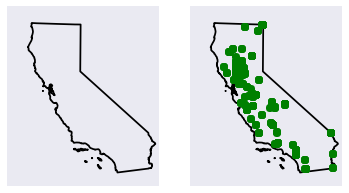

Year: 2014, Month: March
(0, 3) (715, 3)


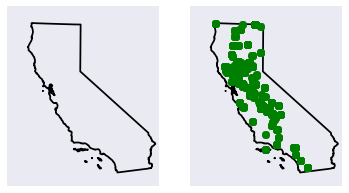

Year: 2015, Month: March
(0, 3) (333, 3)


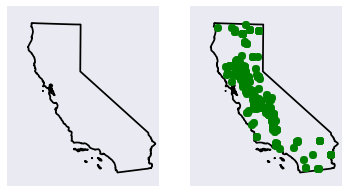

Year: 2012, Month: April
(0, 3) (145, 3)


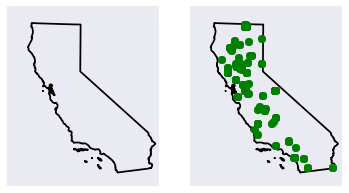

Year: 2013, Month: April
(0, 3) (392, 3)


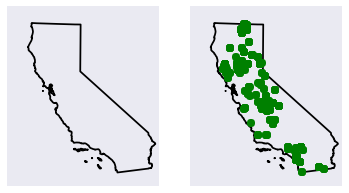

Year: 2014, Month: April
(19, 3) (492, 3)


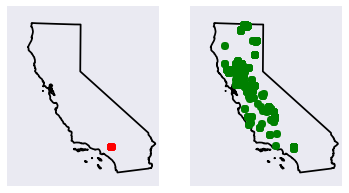

Year: 2015, Month: April
(0, 3) (255, 3)


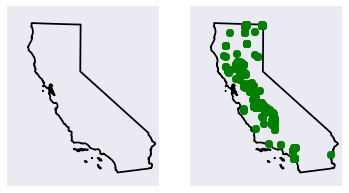

Year: 2012, Month: June
(48, 3) (656, 3)


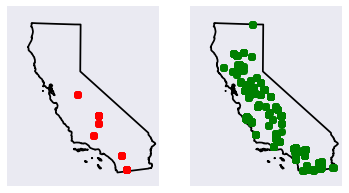

Year: 2013, Month: June
(369, 3) (656, 3)


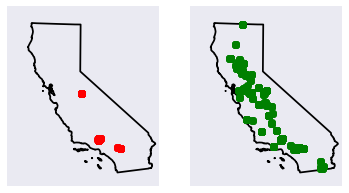

Year: 2014, Month: June
(59, 3) (404, 3)


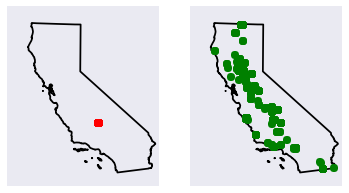

Year: 2015, Month: June
(438, 3) (619, 3)


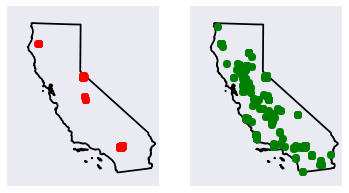

Year: 2012, Month: July
(695, 3) (1147, 3)


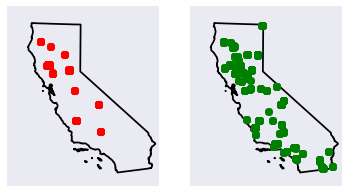

Year: 2013, Month: July
(692, 3) (946, 3)


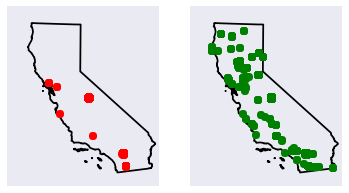

Year: 2014, Month: July
(654, 3) (916, 3)


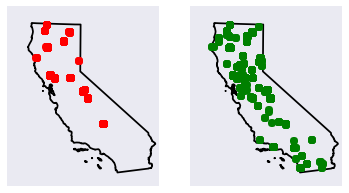

Year: 2015, Month: July
(329, 3) (383, 3)


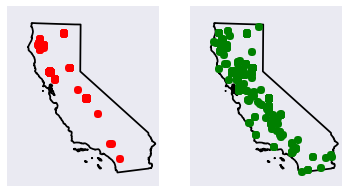

Year: 2012, Month: August
(6391, 3) (8406, 3)


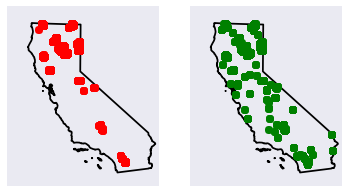

Year: 2013, Month: August
(8096, 3) (4564, 3)


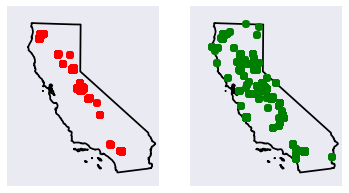

Year: 2014, Month: August
(4420, 3) (3625, 3)


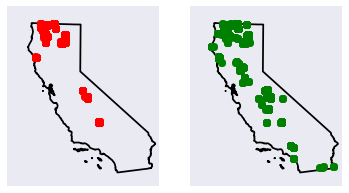

Year: 2015, Month: August
(4829, 3) (5652, 3)


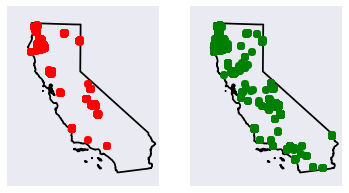

Year: 2012, Month: September
(738, 3) (1372, 3)


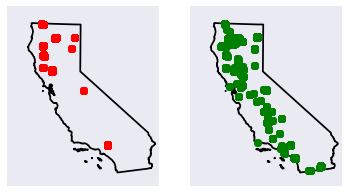

Year: 2013, Month: September
(1700, 3) (1704, 3)


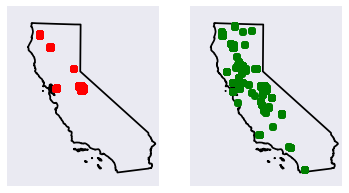

Year: 2014, Month: September
(3826, 3) (2903, 3)


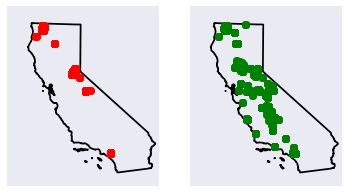

Year: 2015, Month: September
(1022, 3) (896, 3)


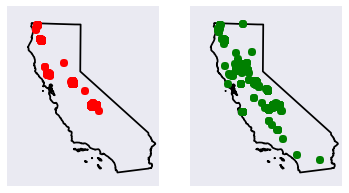

Year: 2012, Month: October
(0, 3) (451, 3)


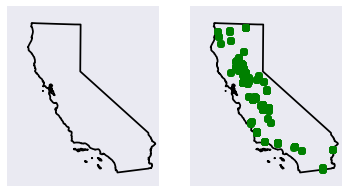

Year: 2013, Month: October
(4, 3) (760, 3)


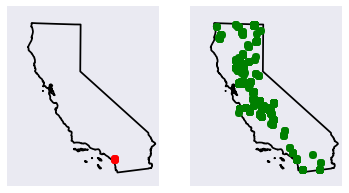

Year: 2014, Month: October
(4, 3) (1033, 3)


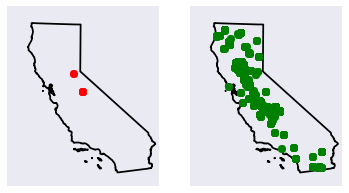

Year: 2015, Month: October
(8, 3) (611, 3)


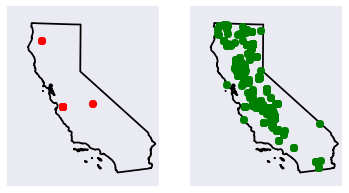

Year: 2012, Month: November
(3, 3) (476, 3)


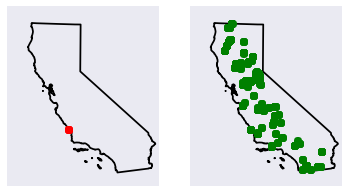

Year: 2013, Month: November
(9, 3) (765, 3)


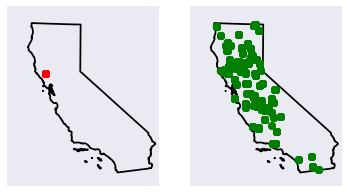

Year: 2014, Month: November
(0, 3) (413, 3)


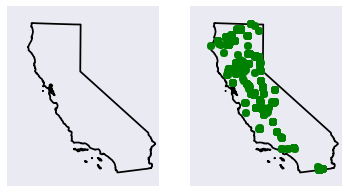

Year: 2015, Month: November
(0, 3) (544, 3)


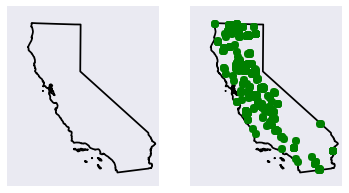

Year: 2012, Month: December
(0, 3) (53, 3)


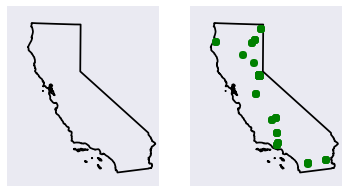

Year: 2013, Month: December
(9, 3) (357, 3)


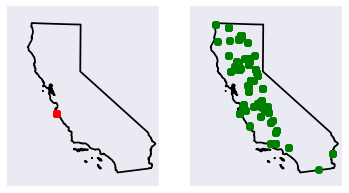

Year: 2014, Month: December
(0, 3) (152, 3)


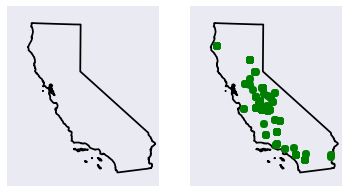

Year: 2015, Month: December
(0, 3) (198, 3)


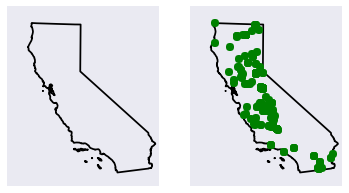

In [6]:
state_names = ['California']
for month in months: 
    for year in years: 
        print 'Year: {}, Month: {}'.format(year, month)
        plot_states(year, state_names, months=[month])

Year: 2012, Month: January
(0, 3) (5, 3)


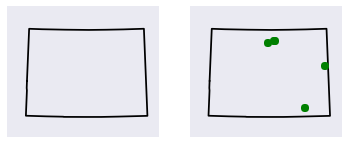

Year: 2013, Month: January
(0, 3) (27, 3)


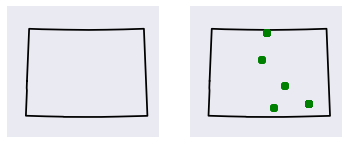

Year: 2014, Month: January
(0, 3) (9, 3)


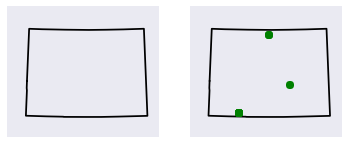

Year: 2015, Month: January
(0, 3) (3, 3)


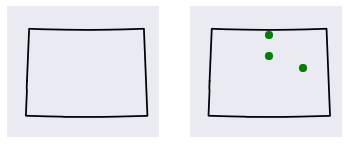

Year: 2012, Month: February
(0, 3) (31, 3)


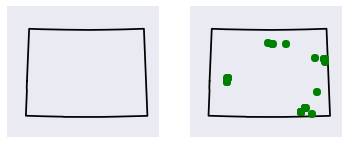

Year: 2013, Month: February
(0, 3) (19, 3)


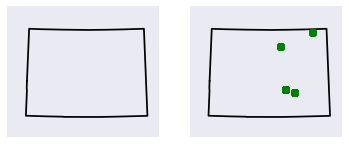

Year: 2014, Month: February
(0, 3) (17, 3)


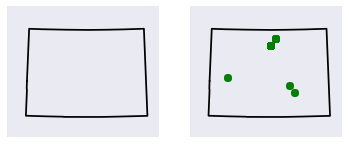

Year: 2015, Month: February
(0, 3) (34, 3)


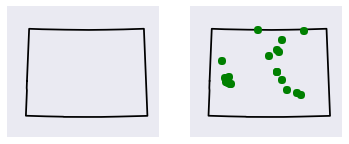

Year: 2012, Month: March
(2, 3) (171, 3)


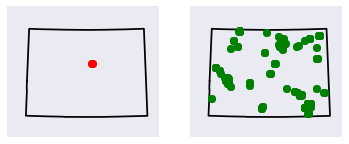

Year: 2013, Month: March
(0, 3) (89, 3)


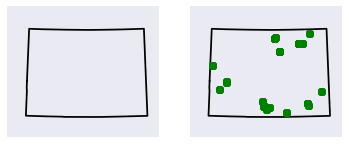

Year: 2014, Month: March
(0, 3) (142, 3)


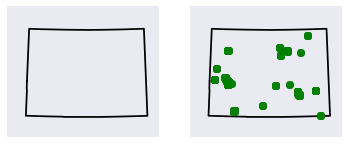

Year: 2015, Month: March
(0, 3) (131, 3)


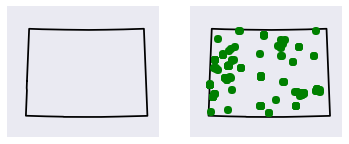

Year: 2012, Month: April
(0, 3) (67, 3)


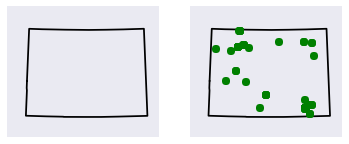

Year: 2013, Month: April
(0, 3) (45, 3)


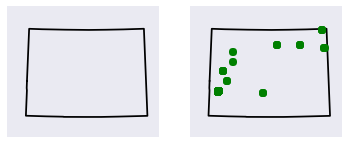

Year: 2014, Month: April
(0, 3) (78, 3)


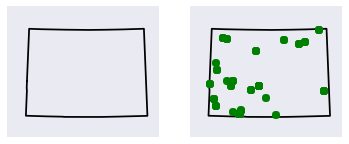

Year: 2015, Month: April
(1, 3) (79, 3)


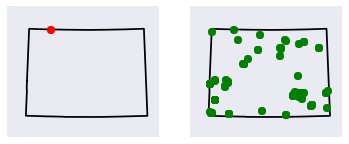

Year: 2012, Month: June
(2066, 3) (1700, 3)


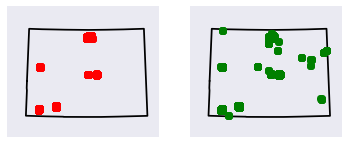

Year: 2013, Month: June
(842, 3) (2130, 3)


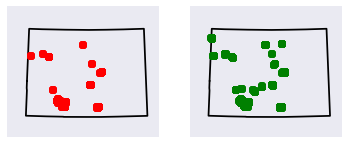

Year: 2014, Month: June
(0, 3) (62, 3)


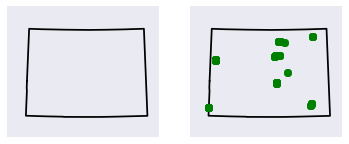

Year: 2015, Month: June
(0, 3) (37, 3)


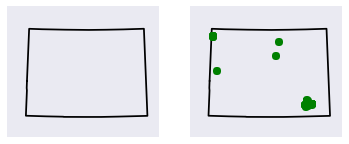

Year: 2012, Month: July
(47, 3) (91, 3)


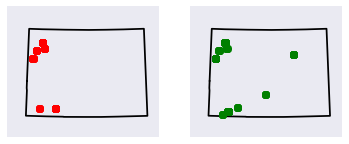

Year: 2013, Month: July
(31, 3) (223, 3)


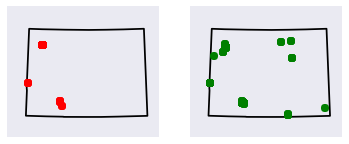

Year: 2014, Month: July
(0, 3) (79, 3)


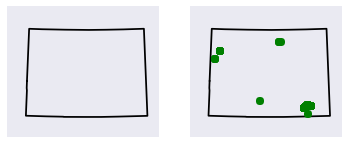

Year: 2015, Month: July
(0, 3) (17, 3)


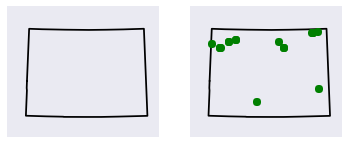

Year: 2012, Month: August
(9, 3) (111, 3)


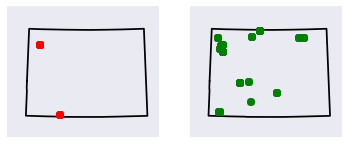

Year: 2013, Month: August
(0, 3) (133, 3)


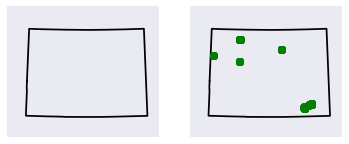

Year: 2014, Month: August
(0, 3) (67, 3)


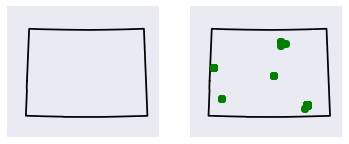

Year: 2015, Month: August
(3, 3) (36, 3)


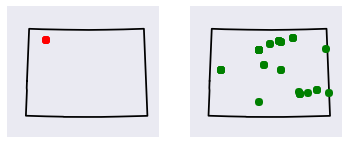

Year: 2012, Month: September
(0, 3) (21, 3)


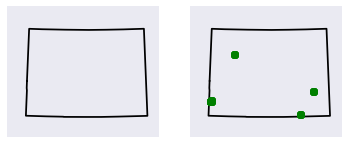

Year: 2013, Month: September
(0, 3) (9, 3)


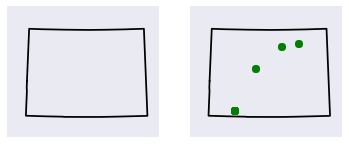

Year: 2014, Month: September
(0, 3) (81, 3)


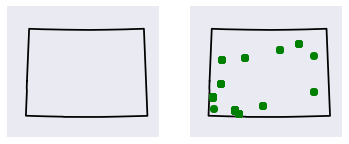

Year: 2015, Month: September
(0, 3) (54, 3)


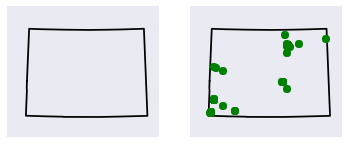

Year: 2012, Month: October
(65, 3) (261, 3)


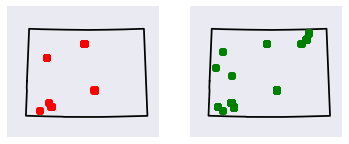

Year: 2013, Month: October
(0, 3) (15, 3)


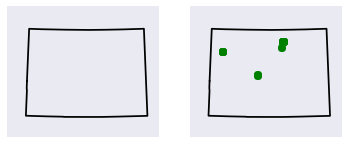

Year: 2014, Month: October
(0, 3) (118, 3)


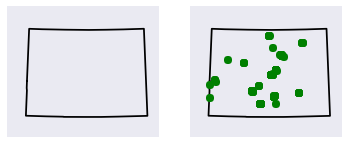

Year: 2015, Month: October
(0, 3) (92, 3)


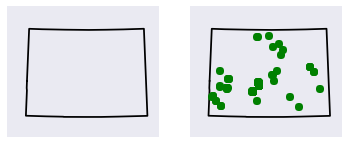

Year: 2012, Month: November
(36, 3) (138, 3)


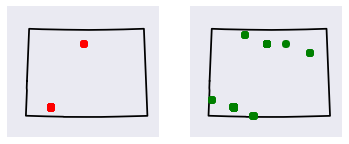

Year: 2013, Month: November
(0, 3) (66, 3)


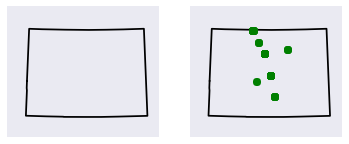

Year: 2014, Month: November
(0, 3) (26, 3)


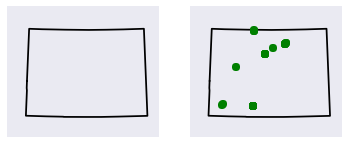

Year: 2015, Month: November
(0, 3) (50, 3)


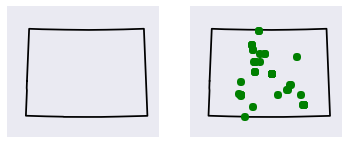

Year: 2012, Month: December
(18, 3) (6, 3)


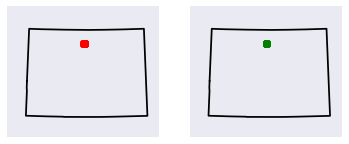

Year: 2013, Month: December
(0, 3) (12, 3)


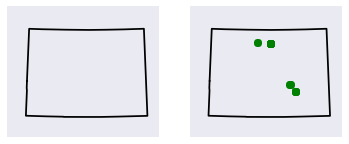

Year: 2014, Month: December
(0, 3) (1, 3)


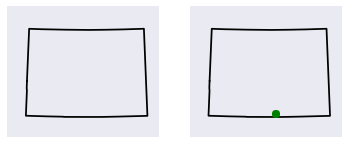

Year: 2015, Month: December
(0, 3) (4, 3)


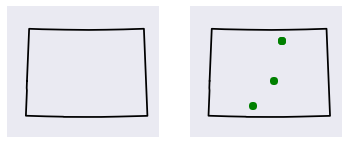

In [6]:
state_names = ['Colorado']
for month in months: 
    for year in years: 
        print 'Year: {}, Month: {}'.format(year, month)
        plot_states(year, state_names, months=[month])

Year: 2012, Month: January
(0, 3) (26, 3)


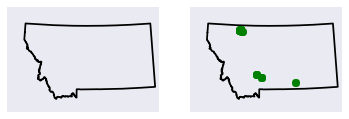

Year: 2013, Month: January
(0, 3) (32, 3)


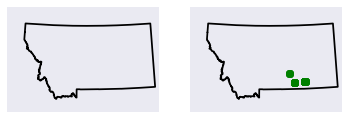

Year: 2014, Month: January
(0, 3) (10, 3)


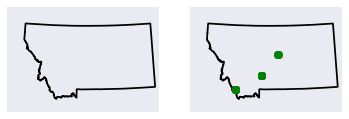

Year: 2015, Month: January
(0, 3) (14, 3)


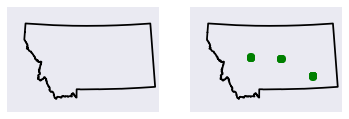

Year: 2012, Month: February
(0, 3) (0, 3)


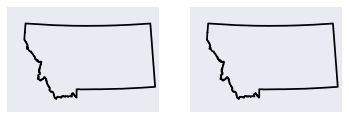

Year: 2013, Month: February
(0, 3) (0, 3)


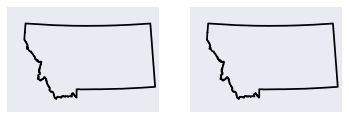

Year: 2014, Month: February
(0, 3) (0, 3)


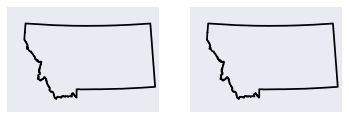

Year: 2015, Month: February
(0, 3) (3, 3)


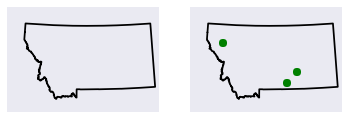

Year: 2012, Month: March
(0, 3) (78, 3)


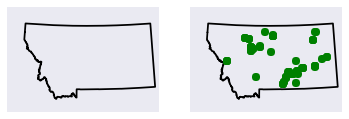

Year: 2013, Month: March
(0, 3) (257, 3)


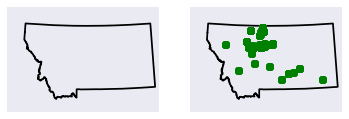

Year: 2014, Month: March
(0, 3) (2, 3)


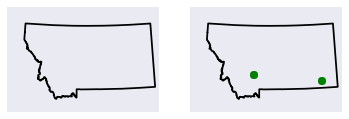

Year: 2015, Month: March
(0, 3) (193, 3)


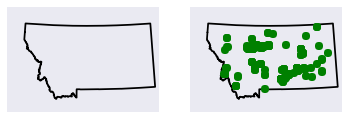

Year: 2012, Month: April
(0, 3) (273, 3)


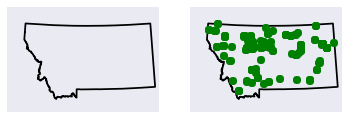

Year: 2013, Month: April
(0, 3) (374, 3)


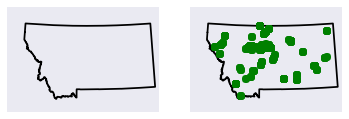

Year: 2014, Month: April
(0, 3) (929, 3)


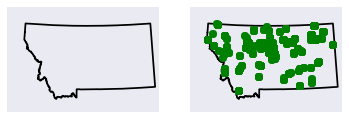

Year: 2015, Month: April
(0, 3) (469, 3)


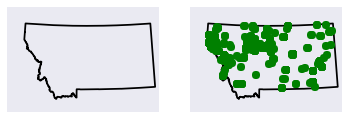

Year: 2012, Month: June
(1563, 3) (1603, 3)


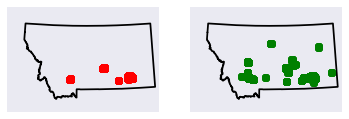

Year: 2013, Month: June
(0, 3) (18, 3)


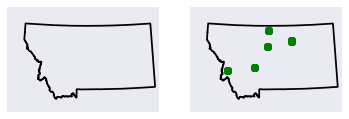

Year: 2014, Month: June
(6, 3) (30, 3)


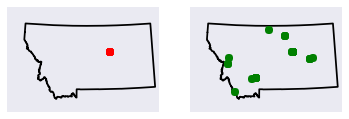

Year: 2015, Month: June
(0, 3) (25, 3)


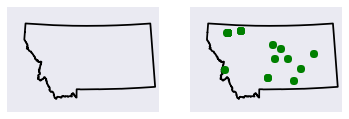

Year: 2012, Month: July
(1953, 3) (1793, 3)


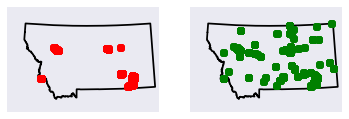

Year: 2013, Month: July
(505, 3) (961, 3)


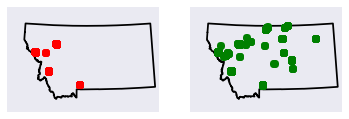

Year: 2014, Month: July
(32, 3) (164, 3)


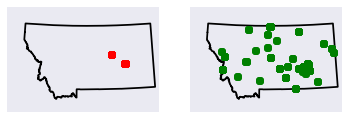

Year: 2015, Month: July
(74, 3) (144, 3)


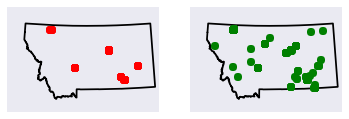

Year: 2012, Month: August
(1572, 3) (3964, 3)


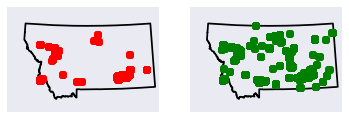

Year: 2013, Month: August
(601, 3) (1474, 3)


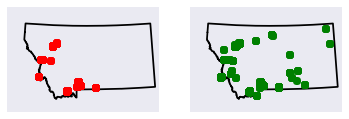

Year: 2014, Month: August
(29, 3) (288, 3)


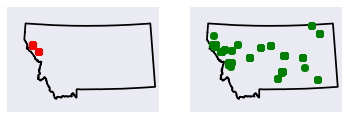

Year: 2015, Month: August
(1272, 3) (3090, 3)


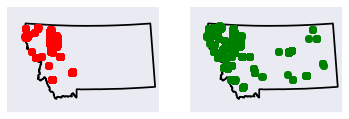

Year: 2012, Month: September
(406, 3) (2045, 3)


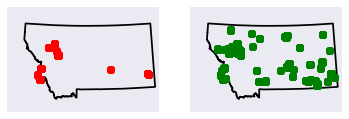

Year: 2013, Month: September
(17, 3) (284, 3)


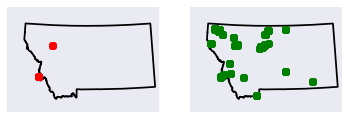

Year: 2014, Month: September
(0, 3) (514, 3)


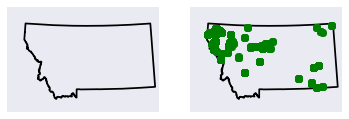

Year: 2015, Month: September
(47, 3) (301, 3)


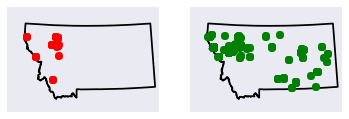

Year: 2012, Month: October
(3, 3) (345, 3)


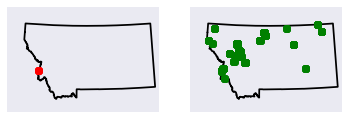

Year: 2013, Month: October
(0, 3) (208, 3)


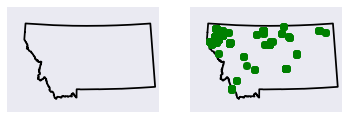

Year: 2014, Month: October
(0, 3) (410, 3)


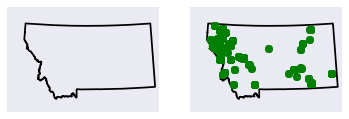

Year: 2015, Month: October
(2, 3) (148, 3)


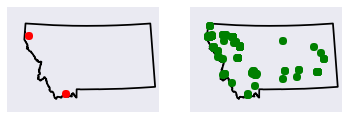

Year: 2012, Month: November
(0, 3) (155, 3)


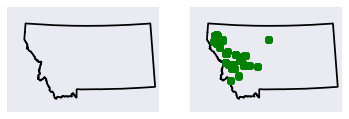

Year: 2013, Month: November
(0, 3) (146, 3)


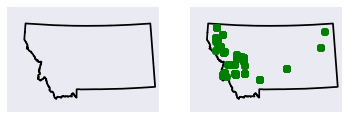

Year: 2014, Month: November
(0, 3) (64, 3)


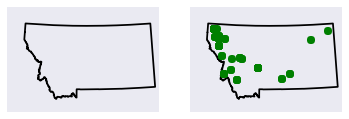

Year: 2015, Month: November
(0, 3) (37, 3)


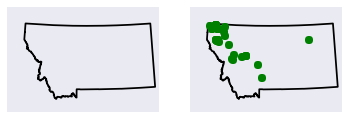

Year: 2012, Month: December
(0, 3) (3, 3)


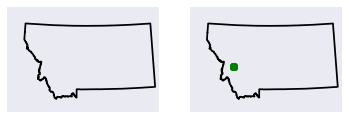

Year: 2013, Month: December
(0, 3) (9, 3)


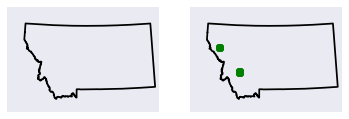

Year: 2014, Month: December
(0, 3) (19, 3)


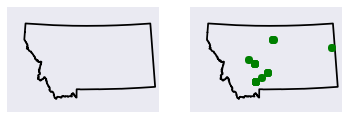

Year: 2015, Month: December
(0, 3) (7, 3)


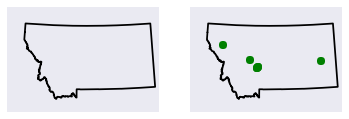

In [7]:
state_names = ['Montana']
for month in months: 
    for year in years: 
        print 'Year: {}, Month: {}'.format(year, month)
        plot_states(year, state_names, months=[month])

Year: 2012, Month: January
(0, 3) (12, 3)


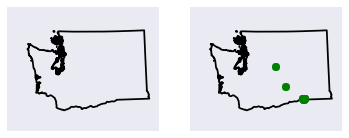

Year: 2013, Month: January
(0, 3) (8, 3)


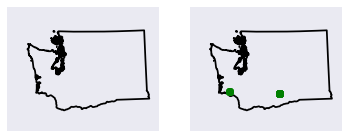

Year: 2014, Month: January
(0, 3) (61, 3)


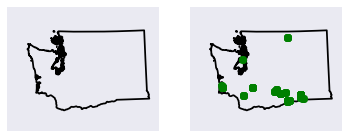

Year: 2015, Month: January
(0, 3) (1, 3)


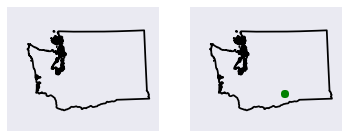

Year: 2012, Month: February
(0, 3) (4, 3)


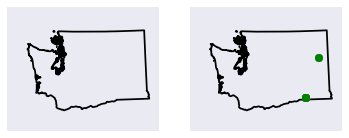

Year: 2013, Month: February
(0, 3) (51, 3)


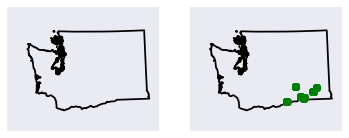

Year: 2014, Month: February
(0, 3) (65, 3)


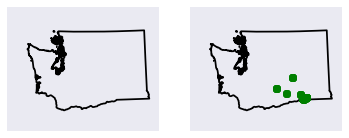

Year: 2015, Month: February
(0, 3) (40, 3)


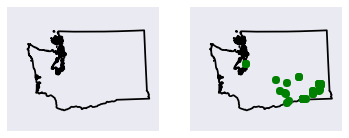

Year: 2012, Month: March
(0, 3) (92, 3)


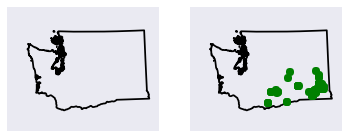

Year: 2013, Month: March
(0, 3) (153, 3)


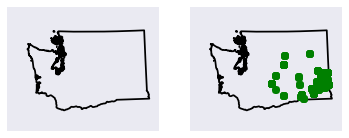

Year: 2014, Month: March
(0, 3) (437, 3)


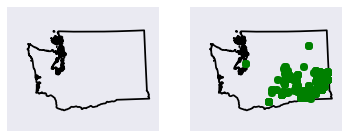

Year: 2015, Month: March
(0, 3) (187, 3)


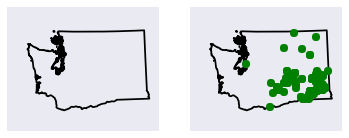

Year: 2012, Month: April
(0, 3) (195, 3)


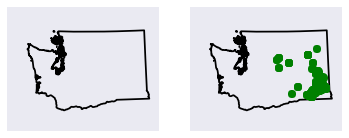

Year: 2013, Month: April
(0, 3) (303, 3)


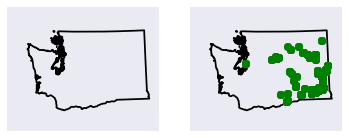

Year: 2014, Month: April
(0, 3) (373, 3)


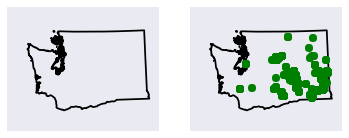

Year: 2015, Month: April
(0, 3) (109, 3)


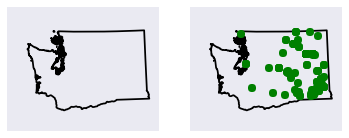

Year: 2012, Month: June
(0, 3) (18, 3)


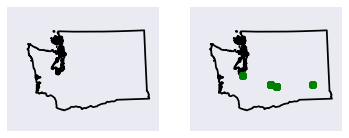

Year: 2013, Month: June
(0, 3) (56, 3)


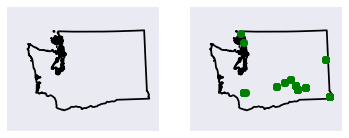

Year: 2014, Month: June
(0, 3) (124, 3)


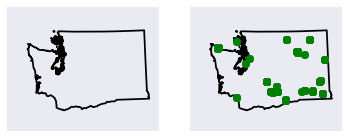

Year: 2015, Month: June
(5, 3) (82, 3)


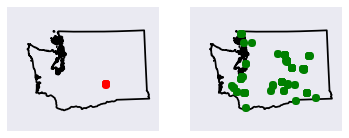

Year: 2012, Month: July
(6, 3) (212, 3)


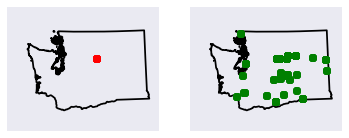

Year: 2013, Month: July
(1092, 3) (871, 3)


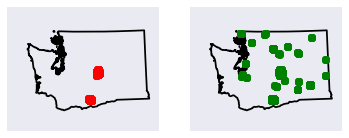

Year: 2014, Month: July
(3376, 3) (2260, 3)


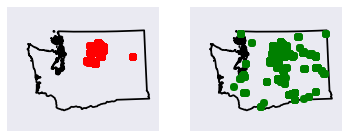

Year: 2015, Month: July
(156, 3) (486, 3)


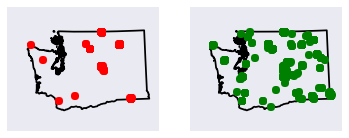

Year: 2012, Month: August
(436, 3) (723, 3)


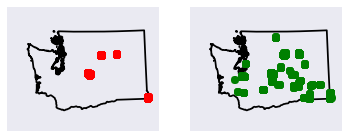

Year: 2013, Month: August
(218, 3) (433, 3)


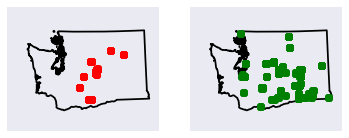

Year: 2014, Month: August
(1941, 3) (2635, 3)


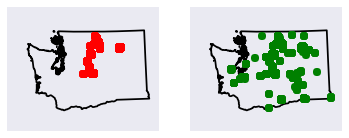

Year: 2015, Month: August
(14647, 3) (10548, 3)


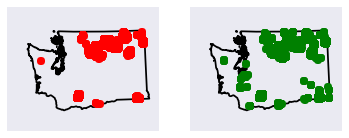

Year: 2012, Month: September
(2774, 3) (3871, 3)


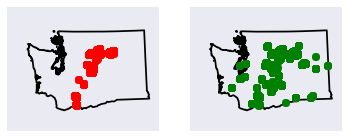

Year: 2013, Month: September
(0, 3) (322, 3)


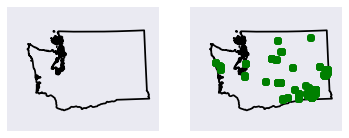

Year: 2014, Month: September
(0, 3) (469, 3)


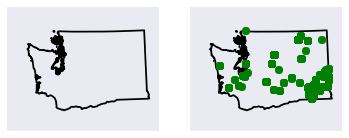

Year: 2015, Month: September
(120, 3) (177, 3)


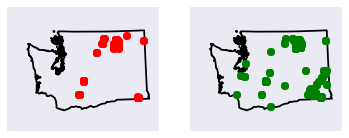

Year: 2012, Month: October
(396, 3) (646, 3)


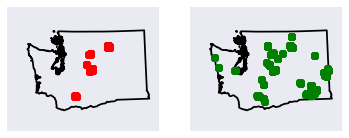

Year: 2013, Month: October
(0, 3) (469, 3)


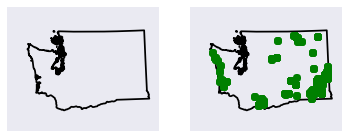

Year: 2014, Month: October
(0, 3) (530, 3)


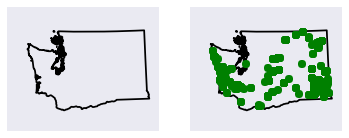

Year: 2015, Month: October
(4, 3) (175, 3)


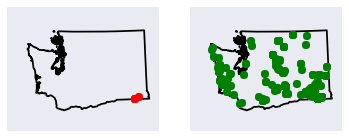

Year: 2012, Month: November
(0, 3) (44, 3)


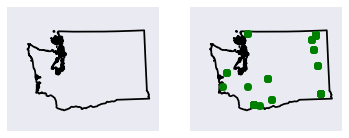

Year: 2013, Month: November
(0, 3) (102, 3)


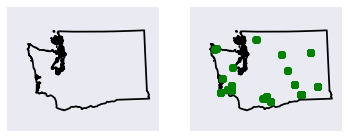

Year: 2014, Month: November
(0, 3) (188, 3)


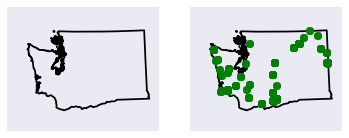

Year: 2015, Month: November
(0, 3) (167, 3)


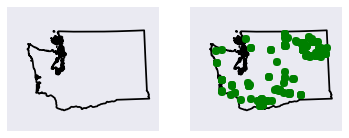

Year: 2012, Month: December
(0, 3) (0, 3)


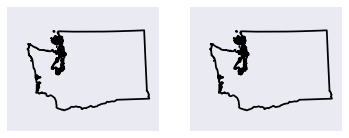

Year: 2013, Month: December
(0, 3) (36, 3)


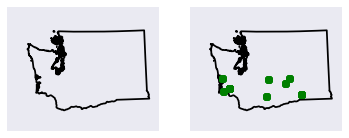

Year: 2014, Month: December
(0, 3) (22, 3)


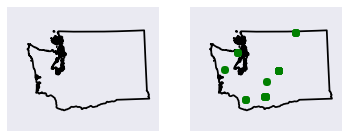

Year: 2015, Month: December
(0, 3) (3, 3)


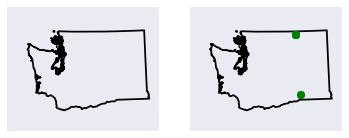

In [6]:
state_names = ['Washington']
for month in months: 
    for year in years: 
        print 'Year: {}, Month: {}'.format(year, month)
        plot_states(year, state_names, months=[month])

Year: 2012, Month: January
(0, 3) (620, 3)


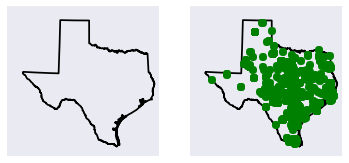

Year: 2013, Month: January
(0, 3) (803, 3)


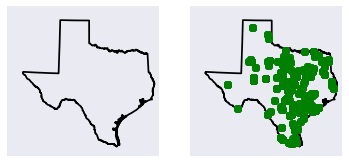

Year: 2014, Month: January
(0, 3) (1624, 3)


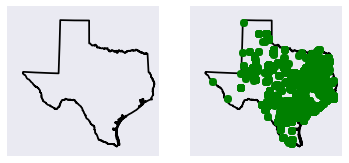

Year: 2015, Month: January
(0, 3) (535, 3)


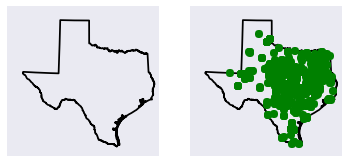

Year: 2012, Month: February
(0, 3) (351, 3)


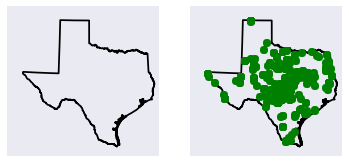

Year: 2013, Month: February
(0, 3) (1520, 3)


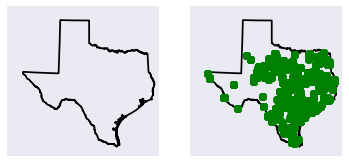

Year: 2014, Month: February
(0, 3) (920, 3)


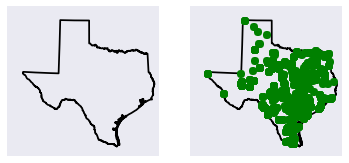

Year: 2015, Month: February
(0, 3) (842, 3)


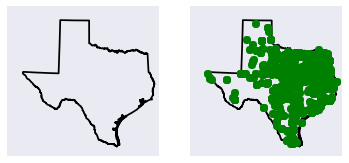

Year: 2012, Month: March
(0, 3) (631, 3)


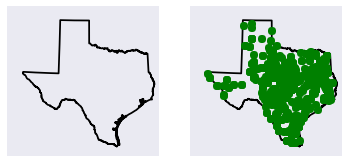

Year: 2013, Month: March
(0, 3) (2754, 3)


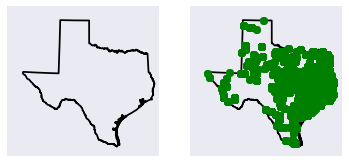

Year: 2014, Month: March
(0, 3) (2012, 3)


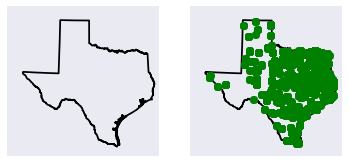

Year: 2015, Month: March
(0, 3) (671, 3)


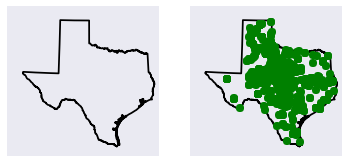

Year: 2012, Month: April
(0, 3) (542, 3)


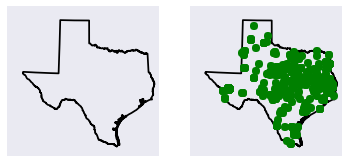

Year: 2013, Month: April
(0, 3) (1388, 3)


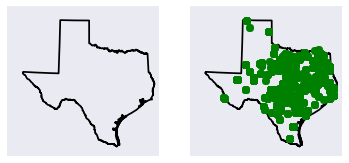

Year: 2014, Month: April
(0, 3) (1722, 3)


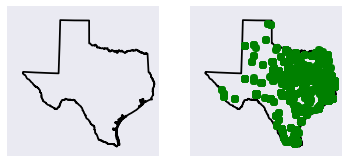

Year: 2015, Month: April
(0, 3) (335, 3)


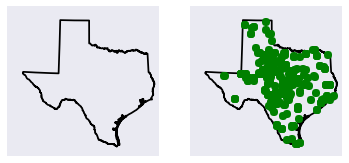

Year: 2012, Month: June
(0, 3) (1024, 3)


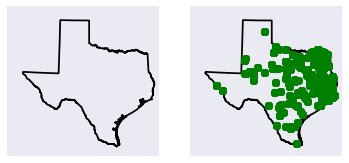

Year: 2013, Month: June
(0, 3) (918, 3)


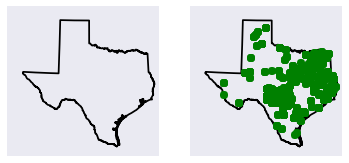

Year: 2014, Month: June
(0, 3) (892, 3)


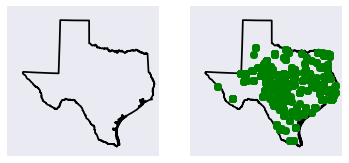

Year: 2015, Month: June
(0, 3) (410, 3)


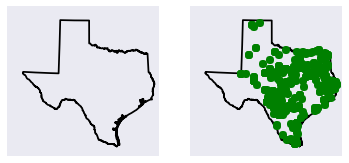

Year: 2012, Month: July
(0, 3) (745, 3)


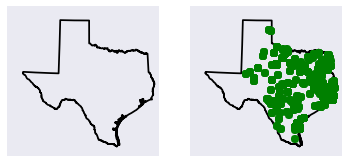

Year: 2013, Month: July
(0, 3) (762, 3)


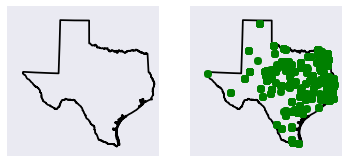

Year: 2014, Month: July
(0, 3) (970, 3)


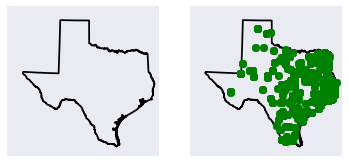

Year: 2015, Month: July
(0, 3) (445, 3)


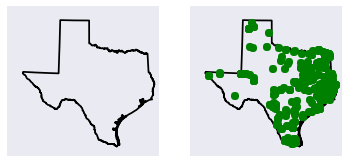

Year: 2012, Month: August
(0, 3) (1019, 3)


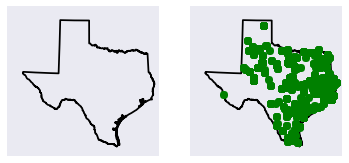

Year: 2013, Month: August
(0, 3) (724, 3)


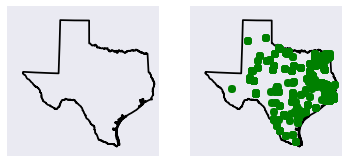

Year: 2014, Month: August
(0, 3) (1029, 3)


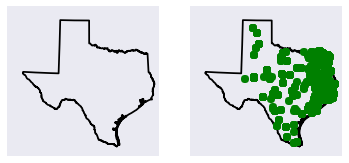

Year: 2015, Month: August
(0, 3) (1036, 3)


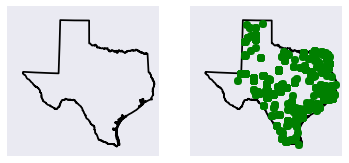

Year: 2012, Month: September
(0, 3) (1515, 3)


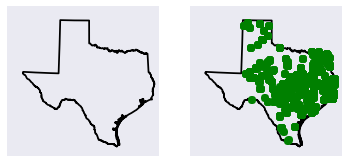

Year: 2013, Month: September
(0, 3) (1469, 3)


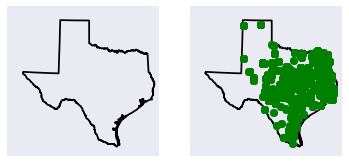

Year: 2014, Month: September
(0, 3) (830, 3)


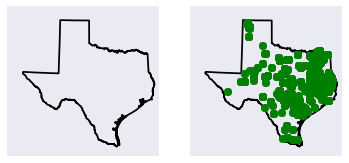

Year: 2015, Month: September
(0, 3) (534, 3)


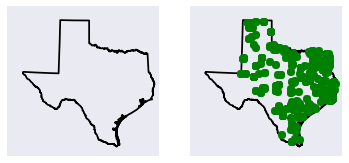

Year: 2012, Month: October
(0, 3) (2206, 3)


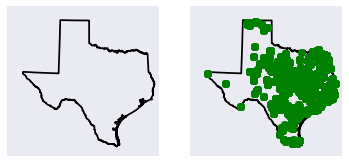

Year: 2013, Month: October
(0, 3) (1512, 3)


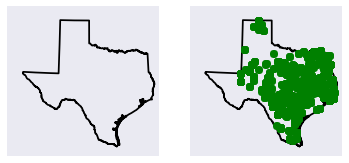

Year: 2014, Month: October
(0, 3) (1665, 3)


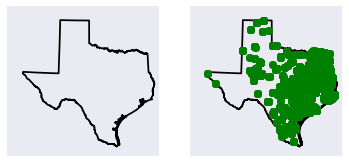

Year: 2015, Month: October
(21, 3) (778, 3)


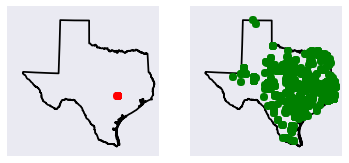

Year: 2012, Month: November
(0, 3) (1304, 3)


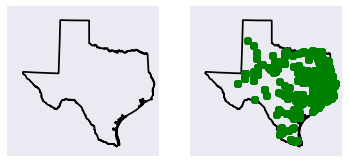

Year: 2013, Month: November
(0, 3) (500, 3)


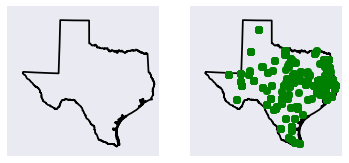

Year: 2014, Month: November
(0, 3) (828, 3)


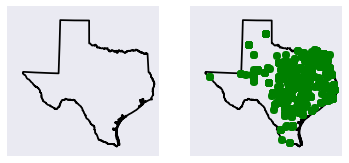

Year: 2015, Month: November
(0, 3) (319, 3)


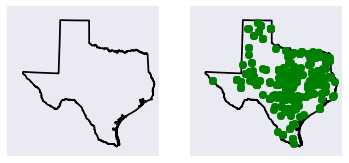

Year: 2012, Month: December
(0, 3) (700, 3)


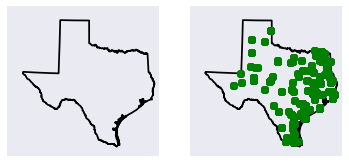

Year: 2013, Month: December
(0, 3) (400, 3)


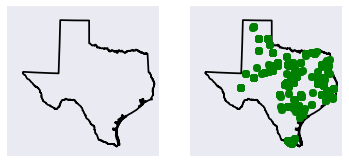

Year: 2014, Month: December
(0, 3) (417, 3)


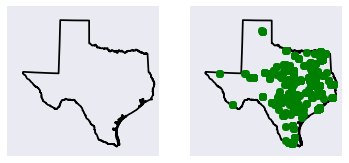

Year: 2015, Month: December
(0, 3) (471, 3)


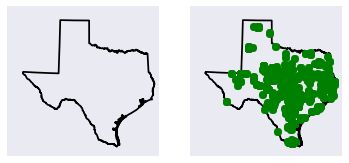

In [7]:
state_names = ['Texas']
for month in months: 
    for year in years: 
        print 'Year: {}, Month: {}'.format(year, month)
        plot_states(year, state_names, months=[month])

In the above set of plots, for each state I have plotted for each year and month of the data (2012-2015): 

1. One plot of the state with all observations that I've labeled as forest-fires (a forest-fire being an observation whose lat/long coordinates fell within a forest-fire perimeter boundary submitted by a state for a given day). This is the left plot, where the forest-fires are plotted as red points. 
2. One plot of the state will all observations that I've labeled as non forest-fires (an observation whose lat/long coordinates did not fall within a forest-fire perimeter boundary submitted by a state for a given day). This is the right plot, where the non forest-fires are plotted as green points. 

From the above plots, it seems clear to me that forest-fire observations do clump together; this was the first pattern that I set out to look for in this notebook. I think that it's pretty easy to see from the above plots that in the left plots with forest-fires, the forest-fires fall into a relatively small, clustered groups. This is strikingly different from the right plots with non forest-fires, where the observations are all over the place; they clearly do not fall into relatively small, clustered groups. To highlight this, we can look at one of the following plots from a year/month of each of the plotted states: 

1. California - June 2013, where 369 forest-fire observations are grouped into three distinct clusters. 
2. Colorado - June 2012, where 2066 forest-fire observations are grouped into five distinct clusters. 
3. Montana - June 2012, where 1593 forest-fire observations are grouped into four distinct clusters. 
4. Washington - July 2013, where 1092 forest-fire observations are grouped into two distinct clusters. 
5. Texas - October 2015, where 21 forest-fire observations are grouped into a distinct cluster (unfortunately this is just about the only month that Texas is showing forest-fires in my data set). 

The presence/absence of the second pattern does not seem apparent to me from the above plots. I think that in order to fully explore this, I need to do these plots in a more aggregate fashion. I think I need to plot the fires/non-fires across year and state, and not plot by month within the years. 

In [5]:
years = ['2012', '2013', '2014', '2015']

Year: 2012
(7881, 3) (13265, 3)


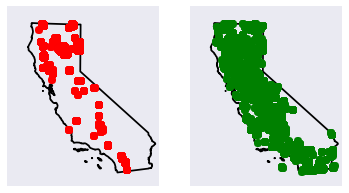

Year: 2013
(11270, 3) (11715, 3)


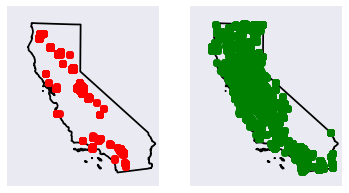

Year: 2014
(9139, 3) (12661, 3)


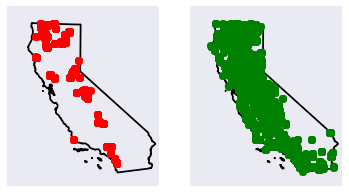

Year: 2015
(6626, 3) (10055, 3)


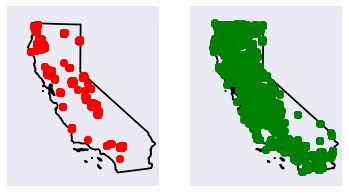

In [6]:
state_names = ['California']
for year in years: 
    print 'Year: {}'.format(year)
    plot_states(year, state_names)

Year: 2012
(2268, 3) (2734, 3)


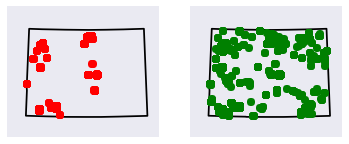

Year: 2013
(873, 3) (2792, 3)


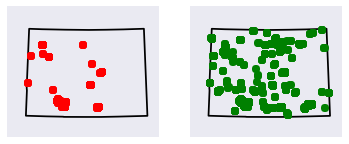

Year: 2014
(0, 3) (749, 3)


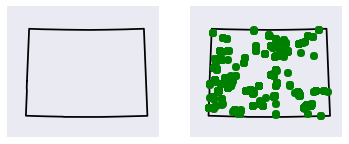

Year: 2015
(4, 3) (560, 3)


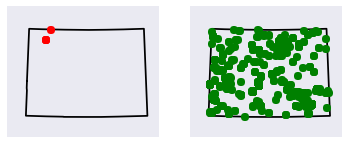

In [7]:
state_names = ['Colorado']
for year in years: 
    print 'Year: {}'.format(year)
    plot_states(year, state_names)

Year: 2012
(5500, 3) (10542, 3)


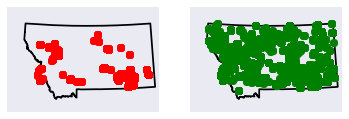

Year: 2013
(1123, 3) (4172, 3)


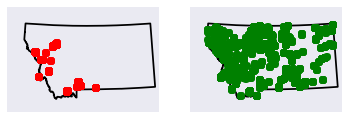

Year: 2014
(67, 3) (2920, 3)


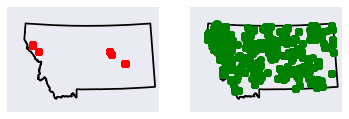

Year: 2015
(1395, 3) (4508, 3)


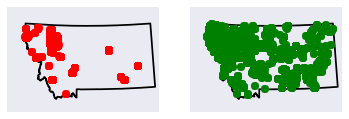

In [8]:
state_names = ['Montana']
for year in years: 
    print 'Year: {}'.format(year)
    plot_states(year, state_names)

Year: 2012
(3612, 3) (5948, 3)


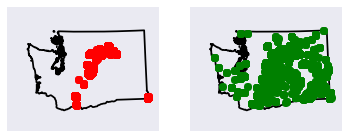

Year: 2013
(1310, 3) (2969, 3)


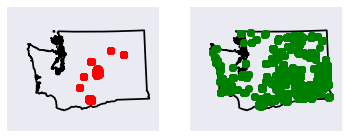

Year: 2014
(5317, 3) (7317, 3)


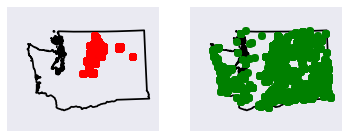

Year: 2015
(14932, 3) (12019, 3)


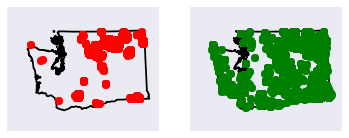

In [9]:
state_names = ['Washington']
for year in years: 
    print 'Year: {}'.format(year)
    plot_states(year, state_names)

Year: 2012
(6, 3) (11278, 3)


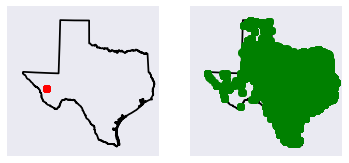

Year: 2013
(0, 3) (13612, 3)


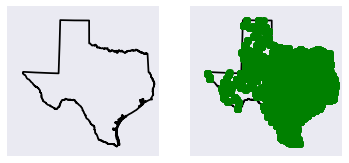

Year: 2014
(0, 3) (13944, 3)


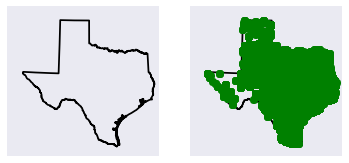

Year: 2015
(21, 3) (6594, 3)


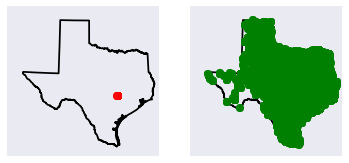

In [10]:
state_names = ['Texas']
for year in years: 
    print 'Year: {}'.format(year)
    plot_states(year, state_names)

If we look at the plots of all fires/non-fires across years, and again across our five states, we have a couple of reasonable looking states, and a couple that look off. 

For California, Washington, and Monatana, we see what looks like a resonable number of forest-fires. Without doing a ton of research or having expertise about the fire landscape for each of these states for the given years, nothing looks out of place. The number of forest-fires that the above plots are showing looks reasonable. 

For Colorado and Texas, however, we see very few, if any, forest-fires in some years. In Colorado, we see no forest-fires in 2014, and only a few (4) in 2015. This seems pretty unlikely, given the historical prevelance of fires in Colorado. If we Google around and do some research about the 2014 fire season, we can find resources that indicate that were fires in this year - [this](http://www.coloradoindependent.com/150405/colorado-wildfire-activity-near-historic-low-this-year) resource suggests that while the 2014 season was mild, there were reasonably sized forest-fires that we would expect to show up in my plots. In Texas, we see no forest-fires in 2013 or 2014, and very few in 2012 and 2015. Again, we can Google around to find evidence that there were forest-fires in Texas in [2013](https://www.ncdc.noaa.gov/sotc/fire/201303), and in [2014](http://amarillo.com/news/local-news/2014-05-16/double-diamond-fire-investigation-cause-continues). 

The lack of forest-fires in CO and TX in those years suggests that one of the following is occuring: 

1. I am not correctly merging potential forest-fires (i.e. their observations lat/long coordinates) into forest-fire perimeter boundaries. 
2. The forest-fire periemter boundaries submitted by states are not complete. 

Either of these seems plausible, although given the fact that we see large numbers of forest-fires in some states and not others, it seems like (2) is more plausible. It seems more likely that the variability is not due to (1), as that would most likely effect all states equally. In that regard, I'm going to start off looking into (2). The first thing to check for (2) is whether or not there are actually any forest-fire perimeter boundaries in my data for those years for CO and TX. It turns out there are; the next step is to work on plotting the perimeter boundaries and trying to visualize why they are not lining up. 